In [1]:
import pickle
import torch.nn as nn
import torch
from torch.nn.utils.rnn import pack_padded_sequence
from data_loader import get_loader
from nltk.translate.bleu_score import corpus_bleu
from vocab import Vocabulary
import gc
from tqdm.notebook import tqdm
import torchvision.models as models
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import json
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import skimage.transform
# from scipy.misc import imread, imresize
from PIL import Image
import matplotlib.image as mpimg
from torchtext.vocab import Vectors, GloVe
from scipy import misc
from pytorch_pretrained_bert import BertTokenizer, BertModel
import imageio

In [2]:
###################
# START Parameters
###################

# hyperparams
grad_clip = 5.
num_epochs = 4
batch_size = 4
decoder_lr = 0.0004

# if both are false them model = baseline

glove_model = False
bert_model = True

from_checkpoint = True
train_model = False
valid_model = True

In [3]:
###################
# END Parameters
###################

# loss
class loss_obj(object):
    def __init__(self):
        self.avg = 0.
        self.sum = 0.
        self.count = 0.

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load pre-trained model (weights)
BertModel = BertModel.from_pretrained('bert-base-uncased').to(device)
BertModel.eval()

# Load GloVe
glove_vectors = pickle.load(open('glove.6B/glove_words.pkl', 'rb'))
glove_vectors = torch.tensor(glove_vectors)



In [4]:
#####################
# Encoder RASNET CNN
#####################
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        resnet = models.resnet101(pretrained=True)
        self.resnet = nn.Sequential(*list(resnet.children())[:-2])
        self.adaptive_pool = nn.AdaptiveAvgPool2d((14, 14))

    def forward(self, images):
        out = self.adaptive_pool(self.resnet(images))
        # batch_size, img size, imgs size, 2048
        out = out.permute(0, 2, 3, 1)
        return out

####################
# Attention Decoder
####################
class Decoder(nn.Module):

    def __init__(self, vocab_size, use_glove, use_bert):
        super(Decoder, self).__init__()
        self.encoder_dim = 2048
        self.attention_dim = 512
        self.use_bert = use_bert

        if use_glove:
            self.embed_dim = 300
        elif use_bert:
            self.embed_dim = 768
        else:
            self.embed_dim = 512

        self.decoder_dim = 512
        self.vocab_size = vocab_size
        self.dropout = 0.5
        
        # soft attention
        self.enc_att = nn.Linear(2048, 512)
        self.dec_att = nn.Linear(512, 512)
        self.att = nn.Linear(512, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

        # decoder layers
        self.dropout = nn.Dropout(p=self.dropout)
        self.decode_step = nn.LSTMCell(self.embed_dim + self.encoder_dim, self.decoder_dim, bias=True)
        self.h_lin = nn.Linear(self.encoder_dim, self.decoder_dim)
        self.c_lin = nn.Linear(self.encoder_dim, self.decoder_dim)
        self.f_beta = nn.Linear(self.decoder_dim, self.encoder_dim)
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(self.decoder_dim, self.vocab_size)

        # init variables
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)
        
        if not use_bert:
            self.embedding = nn.Embedding(vocab_size, self.embed_dim)
            self.embedding.weight.data.uniform_(-0.1, 0.1)

            # load Glove embeddings
            if use_glove:
                self.embedding.weight = nn.Parameter(glove_vectors)

            # always fine-tune embeddings (even with GloVe)
            for p in self.embedding.parameters():
                p.requires_grad = True

    def forward(self, encoder_out, encoded_captions, caption_lengths):    
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size
        dec_len = [x-1 for x in caption_lengths]
        max_dec_len = max(dec_len)

        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)
        num_pixels = encoder_out.size(1)

        # load bert or regular embeddings
        if not self.use_bert:
            embeddings = self.embedding(encoded_captions)
        elif self.use_bert:
            embeddings = []
            for cap_idx in  encoded_captions:
                
                # padd caption to correct size
                while len(cap_idx) < max_dec_len:
                    cap_idx.append(PAD)
                    
                cap = ' '.join([vocab.idx2word[word_idx.item()] for word_idx in cap_idx])
                cap = u'[CLS] '+cap
                
                tokenized_cap = tokenizer.tokenize(cap)                
                indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_cap)
                tokens_tensor = torch.tensor([indexed_tokens]).to(device)

                with torch.no_grad():
                    encoded_layers, _ = BertModel(tokens_tensor)

                bert_embedding = encoded_layers[11].squeeze(0)
                
                split_cap = cap.split()
                tokens_embedding = []
                j = 0

                for full_token in split_cap:
                    curr_token = ''
                    x = 0
                    for i,_ in enumerate(tokenized_cap[1:]): # disregard CLS
                        token = tokenized_cap[i+j]
                        piece_embedding = bert_embedding[i+j]
                        
                        # full token
                        if token == full_token and curr_token == '' :
                            tokens_embedding.append(piece_embedding)
                            j += 1
                            break
                        else: # partial token
                            x += 1
                            
                            if curr_token == '':
                                tokens_embedding.append(piece_embedding)
                                curr_token += token.replace('#', '')
                            else:
                                tokens_embedding[-1] = torch.add(tokens_embedding[-1], piece_embedding)
                                curr_token += token.replace('#', '')
                                
                                if curr_token == full_token: # end of partial
                                    j += x
                                    break                            

                cap_embedding = torch.stack(tokens_embedding)
                embeddings.append(cap_embedding)

            embeddings = torch.stack(embeddings)

        # init hidden state
        avg_enc_out = encoder_out.mean(dim=1)
        h = self.h_lin(avg_enc_out)
        c = self.c_lin(avg_enc_out)

        predictions = torch.zeros(batch_size, max_dec_len, vocab_size).to(device)
        alphas = torch.zeros(batch_size, max_dec_len, num_pixels).to(device)

        for t in range(max(dec_len)):
            batch_size_t = sum([l > t for l in dec_len ])
            
            # soft-attention
            enc_att = self.enc_att(encoder_out[:batch_size_t])
            dec_att = self.dec_att(h[:batch_size_t])
            att = self.att(self.relu(enc_att + dec_att.unsqueeze(1))).squeeze(2)
            alpha = self.softmax(att)
            attention_weighted_encoding = (encoder_out[:batch_size_t] * alpha.unsqueeze(2)).sum(dim=1)
        
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))
            attention_weighted_encoding = gate * attention_weighted_encoding
            
            batch_embeds = embeddings[:batch_size_t, t, :]            
            cat_val = torch.cat([batch_embeds.double(), attention_weighted_encoding.double()], dim=1)
            
            h, c = self.decode_step(cat_val.float(),(h[:batch_size_t].float(), c[:batch_size_t].float()))
            preds = self.fc(self.dropout(h))
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha
            
        # preds, sorted capts, dec lens, attention wieghts
        return predictions, encoded_captions, dec_len, alphas


In [5]:
# vocab indices
PAD = 0
START = 1
END = 2
UNK = 3

# Load vocabulary
with open('./input/vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)

# load data
train_loader = get_loader('train', vocab, batch_size)
val_loader = get_loader('val', vocab, batch_size)


loading annotations into memory...
Done (t=0.60s)
creating index...
index created!
loading annotations into memory...
Done (t=0.41s)
creating index...
index created!


In [6]:
#############
# Init model
#############

criterion = nn.CrossEntropyLoss().to(device)

if from_checkpoint:

    encoder = Encoder().to(device)
    decoder = Decoder(vocab_size=len(vocab),use_glove=glove_model, use_bert=bert_model).to(device)

    if torch.cuda.is_available():
        if bert_model:
            print('Pre-Trained BERT Model')
            encoder_checkpoint = torch.load('./checkpoints/encoder_epoch4')
            decoder_checkpoint = torch.load('./checkpoints/decoder_epoch4')
        elif glove_model:
            print('Pre-Trained GloVe Model')
            encoder_checkpoint = torch.load('./checkpoints/encoder_glove')
            decoder_checkpoint = torch.load('./checkpoints/decoder_glove')
        else:
            print('Pre-Trained Baseline Model')
            encoder_checkpoint = torch.load('./checkpoints/encoder_baseline')
            decoder_checkpoint = torch.load('./checkpoints/decoder_baseline')
    else:
        if bert_model:
            print('Pre-Trained BERT Model')
            encoder_checkpoint = torch.load('./checkpoints/encoder_epoch4', map_location='cpu')
            decoder_checkpoint = torch.load('./checkpoints/decoder_epoch4', map_location='cpu')
        elif glove_model:
            print('Pre-Trained GloVe Model')
            encoder_checkpoint = torch.load('./checkpoints/encoder_glove', map_location='cpu')
            decoder_checkpoint = torch.load('./checkpoints/decoder_glove', map_location='cpu')
        else:
            print('Pre-Trained Baseline Model')
            encoder_checkpoint = torch.load('./checkpoints/encoder_baseline', map_location='cpu')
            decoder_checkpoint = torch.load('./checkpoints/decoder_baseline', map_location='cpu')

    encoder.load_state_dict(encoder_checkpoint['model_state_dict'])
    decoder_optimizer = torch.optim.Adam(params=decoder.parameters(),lr=decoder_lr)
    decoder.load_state_dict(decoder_checkpoint['model_state_dict'])
    decoder_optimizer.load_state_dict(decoder_checkpoint['optimizer_state_dict'])
else:
    encoder = Encoder().to(device)
    decoder = Decoder(vocab_size=len(vocab),use_glove=glove_model, use_bert=bert_model).to(device)
    decoder_optimizer = torch.optim.Adam(params=decoder.parameters(),lr=decoder_lr)



Pre-Trained BERT Model


In [7]:
###############
# Train model
###############

def train():
    print("Started training...")
    for epoch in tqdm(range(num_epochs)):
        decoder.train()
        encoder.train()

        losses = loss_obj()
        num_batches = len(train_loader)

        for i, (imgs, caps, caplens) in enumerate(tqdm(train_loader)):

            imgs = encoder(imgs.to(device))
            caps = caps.to(device)

            scores, caps_sorted, decode_lengths, alphas = decoder(imgs, caps, caplens)
            scores = pack_padded_sequence(scores, decode_lengths, batch_first=True)[0]

            targets = caps_sorted[:, 1:]
            targets = pack_padded_sequence(targets, decode_lengths, batch_first=True)[0]

            loss = criterion(scores, targets).to(device)

            loss += ((1. - alphas.sum(dim=1)) ** 2).mean()

            decoder_optimizer.zero_grad()
            loss.backward()

            # grad_clip decoder
            for group in decoder_optimizer.param_groups:
                for param in group['params']:
                    if param.grad is not None:
                        param.grad.data.clamp_(-grad_clip, grad_clip)

            decoder_optimizer.step()

            losses.update(loss.item(), sum(decode_lengths))

            # save model each 5000 batches
            if i%5000==0 and i!=0:
                print('epoch '+str(epoch+1)+'/4 ,Batch '+str(i)+'/'+str(num_batches)+' loss:'+str(losses.avg))
                
                 # adjust learning rate (create condition for this)
                for param_group in decoder_optimizer.param_groups:
                    param_group['lr'] = param_group['lr'] * 0.8

                print('saving model...')

                torch.save({
                    'epoch': epoch,
                    'model_state_dict': decoder.state_dict(),
                    'optimizer_state_dict': decoder_optimizer.state_dict(),
                    'loss': loss,
                    }, './checkpoints/decoder_mid')

                torch.save({
                    'epoch': epoch,
                    'model_state_dict': encoder.state_dict(),
                    'loss': loss,
                    }, './checkpoints/encode_mid')

                print('model saved')

        torch.save({
            'epoch': epoch,
            'model_state_dict': decoder.state_dict(),
            'optimizer_state_dict': decoder_optimizer.state_dict(),
            'loss': loss,
            }, './checkpoints/decoder_epoch'+str(epoch+1))

        torch.save({
            'epoch': epoch,
            'model_state_dict': encoder.state_dict(),
            'loss': loss,
            }, './checkpoints/encoder_epoch'+str(epoch+1))

        print('epoch checkpoint saved')

    print("Completed training...")  



In [8]:
#################
# Validate model
#################

def print_sample(hypotheses, references, test_references,imgs, alphas, k, show_att, losses):
    bleu_1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0))
    bleu_2 = corpus_bleu(references, hypotheses, weights=(0, 1, 0, 0))
    bleu_3 = corpus_bleu(references, hypotheses, weights=(0, 0, 1, 0))
    bleu_4 = corpus_bleu(references, hypotheses, weights=(0, 0, 0, 1))

    print("Validation loss: "+str(losses.avg))
    print("BLEU-1: "+str(bleu_1))
    print("BLEU-2: "+str(bleu_2))
    print("BLEU-3: "+str(bleu_3))
    print("BLEU-4: "+str(bleu_4))

    img_dim = 336 # 14*24
    
    hyp_sentence = []
    for word_idx in hypotheses[k]:
        hyp_sentence.append(vocab.idx2word[word_idx])
    
    ref_sentence = []
    for word_idx in test_references[k]:
        ref_sentence.append(vocab.idx2word[word_idx])

    print('Hypotheses: '+" ".join(hyp_sentence))
    print('References: '+" ".join(ref_sentence))
        
    img = imgs[0][k] 
    imageio.imwrite('img.jpg', img)
  
    if show_att:
        image = Image.open('img.jpg')
        image = image.resize([img_dim, img_dim], Image.LANCZOS)
        for t in range(len(hyp_sentence)):

            plt.subplot(np.ceil(len(hyp_sentence) / 5.), 5, t + 1)

            plt.text(0, 1, '%s' % (hyp_sentence[t]), color='black', backgroundcolor='white', fontsize=12)
            plt.imshow(image)
            current_alpha = alphas[0][t, :].detach().numpy()
            alpha = skimage.transform.resize(current_alpha, [img_dim, img_dim])
            if t == 0:
                plt.imshow(alpha, alpha=0)
            else:
                plt.imshow(alpha, alpha=0.7)
            plt.axis('off')
    else:
        img = imageio.imread('img.jpg')
        plt.imshow(img)
        plt.axis('off')
        plt.show()



In [9]:
def validate():

    references = [] 
    test_references = []
    hypotheses = [] 
    all_imgs = []
    all_alphas = []

    print("Started validation...")
    decoder.eval()
    encoder.eval()

    losses = loss_obj()

    num_batches = len(val_loader)
    # Batches
    for i, (imgs, caps, caplens) in enumerate(tqdm(val_loader)):

        imgs_jpg = imgs.numpy() 
        imgs_jpg = np.swapaxes(np.swapaxes(imgs_jpg, 1, 3), 1, 2)
        
        # Forward prop.
        imgs = encoder(imgs.to(device))
        caps = caps.to(device)

        scores, caps_sorted, decode_lengths, alphas = decoder(imgs, caps, caplens)
        targets = caps_sorted[:, 1:]

        # Remove timesteps that we didn't decode at, or are pads
        scores_packed = pack_padded_sequence(scores, decode_lengths, batch_first=True)[0]
        targets_packed = pack_padded_sequence(targets, decode_lengths, batch_first=True)[0]

        # Calculate loss
        loss = criterion(scores_packed, targets_packed)
        loss += ((1. - alphas.sum(dim=1)) ** 2).mean()
        losses.update(loss.item(), sum(decode_lengths))

         # References
        for j in range(targets.shape[0]):
            img_caps = targets[j].tolist() # validation dataset only has 1 unique caption per img
            clean_cap = [w for w in img_caps if w not in [PAD, START, END]]  # remove pad, start, and end
            img_captions = list(map(lambda c: clean_cap,img_caps))
            test_references.append(clean_cap)
            references.append(img_captions)

        # Hypotheses
        _, preds = torch.max(scores, dim=2)
        preds = preds.tolist()
        temp_preds = list()
        for j, p in enumerate(preds):
            pred = p[:decode_lengths[j]]
            pred = [w for w in pred if w not in [PAD, START, END]]
            temp_preds.append(pred)  # remove pads, start, and end
        preds = temp_preds
        hypotheses.extend(preds)
        
        if i == 0:
            all_alphas.append(alphas)
            all_imgs.append(imgs_jpg)
#         gc.collect();
        torch.cuda.empty_cache()

    print("Completed validation...")
    print_sample(hypotheses, references, test_references, all_imgs, all_alphas,1,False, losses)

Started validation...


  0%|          | 0/50664 [00:00<?, ?it/s]

Completed validation...


Lossy conversion from float32 to uint8. Range [-2.1179039478302, 2.640000104904175]. Convert image to uint8 prior to saving to suppress this warning.


Validation loss: 2.2565664416450812
BLEU-1: 0.737800898401742
BLEU-2: 0.5311405471723185
BLEU-3: 0.39646531472676955
BLEU-4: 0.30347168478324926
Hypotheses: a view of the road road seen from a on motorcycle .
References: the view of the road as seen from riding a motorcycle .


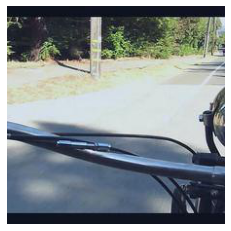

In [10]:
######################
# Run training/validation
######################

if train_model:
    train()

if valid_model:
    validate()

In [11]:
for i in range(100):
#     torch.cuda.empty_cache()
    gc.collect();